## Robert Birek - Mod. 9 zad. 1 

Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i tempo na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



## 01. Wczytuję dane z Digital Ocean

### Instalki

In [ ]:
!pip install --quiet boto3==1.35.99
!pip install s3fs

### Importy

In [64]:
import pandas as pd
import os
import glob
import re
import boto3
from pycaret.regression import *
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itables import init_notebook_mode


ENDPOINT_URL = f"https://fra1.digitaloceanspaces.com"
BUCKET_NAME = "gotoit.robertbirek"

load_dotenv()

True

### Sprawdzam połączenie z DO

In [65]:
s3_client = boto3.client("s3", endpoint_url=ENDPOINT_URL)

try:
    s3_client.head_bucket(Bucket=BUCKET_NAME)
    print("Połączenie z S3 działa poprawnie")
except Exception as e:
    print(f"Błąd połączenia z S3: {str(e)}")

Połączenie z S3 działa poprawnie


### Listuję pliki w DO

In [66]:
def list_files_in_cloud(s3):
    try:
        response = s3.list_objects_v2(Bucket=BUCKET_NAME)
        if "Contents" in response:
            return [obj["Key"] for obj in response["Contents"]]
        else:
            return []
    except Exception as e:
        print(f"Błąd połączenia z S3: {str(e)}")
        return []

In [67]:

files = list_files_in_cloud(s3_client)
print("📂 Lista plików w S3:")
for file in files:
    print(f" - {file}")

📂 Lista plików w S3:
 - current/all_cleaned.csv
 - current/halfmarathon_wroclaw_2023__final_cleaned.csv
 - current/halfmarathon_wroclaw_2024__final_cleaned.csv
 - current/model_5kplace.pkl
 - current/model_place.pkl
 - current/model_tempo.pkl
 - raw/halfmarathon_wroclaw_2023__final.csv
 - raw/halfmarathon_wroclaw_2024__final.csv


### Pobieram lokalnie

In [68]:
REMOTE_FOLDER = "raw/"  # Folder na S3
LOCAL_RAW_FOLDER = "data/raw/"  # Lokalny folder docelowy
LOCAL_CURRENT_FOLDER = "data/current/"  # Lokalny folder z danymi do predykcji

# Upewnienie się, że folder lokalny istnieje
os.makedirs(LOCAL_RAW_FOLDER, exist_ok=True)

In [69]:
def download_csv_from_cloud(s3,remote_folder,local_folder):
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=BUCKET_NAME, Prefix=remote_folder):
        if "Contents" in page:
            for obj in page["Contents"]:
                remote_path = obj["Key"]
                file_name = os.path.basename(remote_path)

                # Pobieramy tylko pliki CSV
                if not file_name.endswith(".csv"):
                    continue

                local_path = os.path.join(local_folder, file_name)
                s3.download_file(BUCKET_NAME, remote_path, local_path)
                print(f"📥 Pobrano plik {remote_path} -> {local_path}")
    

In [70]:
download_csv_from_cloud(s3_client,REMOTE_FOLDER,LOCAL_RAW_FOLDER)

📥 Pobrano plik raw/halfmarathon_wroclaw_2023__final.csv -> data/raw/halfmarathon_wroclaw_2023__final.csv
📥 Pobrano plik raw/halfmarathon_wroclaw_2024__final.csv -> data/raw/halfmarathon_wroclaw_2024__final.csv


## 02. Czyszczę dane

Postanowiłem wyczyścić każdy plik oddzielnie, zależy mi na autlaiersach osobno w każdym roku, traktuję każdy bieg z osobna, ponieważ w każdym roku są inne parametry biegu. 
Na końcu je łączę w jeden.

Funkcje pomocnicze:

In [71]:
def convert_time_to_seconds(time):
    try:
        h, m, s = map(int, time.split(':'))
        return h * 3600 + m * 60 + s
    except (ValueError, AttributeError):
        return None  

In [72]:
def convert_tempo_to_seconds(tempo):
    # Obsługa przypadku, gdy tempo to NaN
    if pd.isnull(tempo):
        return None 
    try:
        # Rozdziel minuty i sekundy
        minutes = int(tempo)  # Całkowita część to minuty
        seconds = (tempo - minutes) * 100  # Część dziesiętna to sekundy
        # Zamień na sekundy
        total_seconds = int(minutes * 60 + seconds)
        return total_seconds
    except (ValueError, AttributeError):
        return None

In [73]:
# Funkcja wyciągająca rok urodzenia z "Kategoria wiekowa"
def estimate_rocznik(category, current_year=2025):
    if isinstance(category, str):
        match = re.search(r'\d+', category)
        if match:
            avg_age = int(match.group()) + 5  # Środek przedziału (np. 30-39 -> 35)
            return current_year - avg_age
    return None

In [74]:
# Funkcja do wyliczenia kategorii wiekowej na podstawie 'Rocznik' i 'Płeć'
def calculate_kategoria_wiekowa(plec, rocznik, current_year=2025):
    if pd.notna(rocznik) and pd.notna(plec):
        age = current_year - int(rocznik)
        category = (age // 10) * 10  # Zaokrąglenie w dół do dziesiątek
        return f"{plec}{category}"
    return None

In [77]:
def clean_data(csv_files):
    if not csv_files:
        print("Brak plików CSV w folderze.")
        return False #Brak plików CSV w folderze.

    try:
        # Obecny rok
        current_year = datetime.now().year
        # Generowanie listy ostatnich 5 lat
        target_year = list(range(current_year - 4, current_year + 1))
        print(f"Pobireram pliki z ostatnich 5 lat: {', '.join(map(str, target_year))}")
        
        for file in csv_files:
            matching_years = [str(year) for year in target_year if str(year) in os.path.basename(file)]          
            # Sprawdzanie, czy w nazwie pliku jest któryś z lat z target_year
            if matching_years:
                print(f"Wczytywanie danych z roku {', '.join(matching_years)}...")
                # Wczytanie danych
                df_raw = pd.read_csv(file, sep=";")
                dfp = df_raw.sample(20, random_state=42)
                dfp
                print(f"Czyszczenie danych w pliku {file} ...")
                df = df_raw.copy()
                # Zamieniam nazwy kolumn 
                print("Zmiana nazw kolumn na małe litery i zamiana spacji na podkreślenia")
                df.columns = df.columns.str.replace(' ', '_').str.lower()
                df.sample(20, random_state=42)
                # Usuwanie wierszy z czasem DNS, DNF lub brakiem czasu
                print("Usuwanie wierszy z czasem DNS, DNF lub brakiem czasu")
                df = df[~df['czas'].isin(['DNS', 'DNF']) & df['czas'].notnull()]
                df.sample(20, random_state=42)
                #usuwam kolumny anonimizacja
                print("Anonimizacja - Usuwanie kolumn: imię, nazwisko, miasto, kraj, drużyna")
                df.drop(['imię', 'nazwisko', 'miasto', 'kraj','drużyna'], axis=1, inplace=True)
                df.sample(20, random_state=42)
                # Zamieniam kolumny Czas = Czas w sek
                print("Zamieniam kolumny czas na czas w sekundach")
                czas_columns = ['czas', '5_km_czas', '10_km_czas', '15_km_czas', '20_km_czas']
                for col in czas_columns:
                    df[col] = df[col].apply(convert_time_to_seconds)
                
                # Zamieniam kolumny tempo min/km na sek/km
                print("Zamieniam kolumny tempo min/km na sekundy/km")
                tempo_columns = ['5_km_tempo','10_km_tempo', '15_km_tempo', '20_km_tempo','tempo_stabilność','tempo']  # Replace with actual column names
                for col in tempo_columns:
                    df[col] = df[col].apply(convert_tempo_to_seconds)
                #sortuję rosnąco po miejsce
                df.sort_values(by='miejsce', ascending=True, inplace=True)
                #uzupełniam puste dane interpolując
                interp_columns = ['5_km_czas','5_km_miejsce_open','5_km_tempo', '10_km_czas','10_km_miejsce_open','10_km_tempo', '15_km_czas','15_km_miejsce_open','15_km_tempo', '20_km_czas','20_km_miejsce_open','20_km_tempo']
                for col in interp_columns:
                    df[col] = df[col].interpolate(method='linear')
                
                # Uzupełnianie brakujących wartości w kolumnie 'Rocznik'
                df['rocznik'] = df['rocznik'].fillna(
                    df['kategoria_wiekowa'].apply(estimate_rocznik)
                )
                
                # Uzupełnianie braków w kolumnie 'Kategoria wiekowa'
                df['kategoria_wiekowa'] = df['kategoria_wiekowa'].fillna(
                    df.apply(
                        lambda row: calculate_kategoria_wiekowa(row['płeć'], row['rocznik']),
                        axis=1
                    )
                )
                # Wypełnianie braków w kolumnie 'Kategoria wiekowa Miejsce'
                df['kategoria_wiekowa_miejsce'] = df.groupby('kategoria_wiekowa').cumcount() + 1

                # Uzupełnij puste wartości w kolumnie 'tempo_stabilność' odchyleniem standardowym z odcinków
                # Lista kolumn z tempem dla różnych odcinków biegu
                tempo_columns = ['5_km_tempo','10_km_tempo', '15_km_tempo', '20_km_tempo']
                # Obliczenie odchylenia standardowego tempa dla każdego uczestnika
                df['tempo_stabilność'] = df['tempo_stabilność'].fillna(df[tempo_columns].std(axis=1))
                #df['tempo_stabilność'] = df['tempo_stabilność'].fillna(df['tempo_stabilność'].median())
                
                # Zamieniam kolumny na liczby całkowite
                # Wybierz tylko kolumny liczbowe
                numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

                # Konwersja tylko kolumn liczbowych na int
                df[numeric_columns] = df[numeric_columns].astype(int)
                
                # int_columns = ['miejsce','płeć_miejsce', 'rocznik']
                # for col in int_columns:
                #     df[col] = df[col].astype(int)
                
                #zamieniam płeć K=0 M=1
                df['płeć'] = df['płeć'].map({'K': 0, 'M': 1})

                # Usuwanie gdy rocznik=0
                df = df[df["rocznik"] != 0]
                #dodaje kolumnę wiek, oblicza wiek w czasie biegu
                # Wyodrębnienie roku maratonu z nazwy pliku lub użycie aktualnego roku
                current_year = datetime.now().year
                
                match = re.search(r'\d{4}', file)
                if match:
                    marathon_year = int(match.group())
                else:
                    marathon_year = current_year

                # Obliczenie wieku uczestnika w czasie biegu
                df['wiek'] = marathon_year - df['rocznik']
                df['rok'] = marathon_year

                print("Sprawdzam ile jest wartości none")
                df.isna().sum()

                # Wartości odstających możemy się pozbyć używając np. tzw. IQR (Interquartile Range)
                Q1 = df["czas"].quantile(0.25)
                Q3 = df["czas"].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df_outliers = df[(df["czas"] >= lower_bound) & (df["czas"] <= upper_bound)]

                # Metoda odchylenia standardowego Obliczenie średniej i odchylenia standardowego
                # mean = df["czas"].mean()
                # std_dev = df["czas"].std()
                # stlower_bound = mean - 3 * std_dev
                # stupper_bound = mean + 3 * std_dev
                # df_outliers_st = df[(df["czas"] >= stlower_bound) & (df["czas"] <= stupper_bound)]

                fig, ax = plt.subplots(figsize=(10, 5))
                # Dane z wartościami odstającymi
                sns.scatterplot(data=df, x="czas", y="rocznik", ax=ax, color="red", linewidth=0, alpha=0.5, label="Z wartościami odstającymi")
                # Dane bez wartości odstających
                sns.scatterplot(data=df_outliers, x="czas", y="rocznik", ax=ax, color="blue", linewidth=0, alpha=0.5, label="Bez wartości odstających")
                # Dodanie tytułu i legendy
                ax.set_title("Porównanie danych z i bez wartości odstających")
                ax.legend()
                plt.tight_layout()
                plt.show()

                fig, ax = plt.subplots(figsize=(10, 5))
                # Dane z wartościami odstającymi
                sns.scatterplot(data=df, x="czas", y="miejsce", ax=ax, color="red", linewidth=0, alpha=0.5, label="Z wartościami odstającymi")
                # Dane bez wartości odstających
                sns.scatterplot(data=df_outliers, x="czas", y="miejsce", ax=ax, color="blue", linewidth=0, alpha=0.5, label="Bez wartości odstających")
                # Dodanie tytułu i legendy
                ax.set_title("Porównanie danych z i bez wartości odstających")
                ax.legend()
                plt.tight_layout()
                plt.show()


                #zapisuję plik
                output_file_name = os.path.basename(file).replace(".csv", "_cleaned.csv")
                output_file_path = os.path.join(LOCAL_CURRENT_FOLDER, output_file_name)
                df.to_csv(output_file_path, index=False, sep=";")
                # df_outliers.to_csv(output_file_path, index=False, sep=";")

            else:
                print(f"Plik {file} nie zawiera w nazwie żadnego z lat {target_year}. Pomijam ten plik.")
    except Exception as e:
        print(f"Błąd podczas czyszczenia danych: {e}")

Pobireram pliki z ostatnich 5 lat: 2021, 2022, 2023, 2024, 2025
Wczytywanie danych z roku 2023...
Czyszczenie danych w pliku data/raw\halfmarathon_wroclaw_2023__final.csv ...
Zmiana nazw kolumn na małe litery i zamiana spacji na podkreślenia
Usuwanie wierszy z czasem DNS, DNF lub brakiem czasu
Anonimizacja - Usuwanie kolumn: imię, nazwisko, miasto, kraj, drużyna
Zamieniam kolumny czas na czas w sekundach
Zamieniam kolumny tempo min/km na sekundy/km
Sprawdzam ile jest wartości none


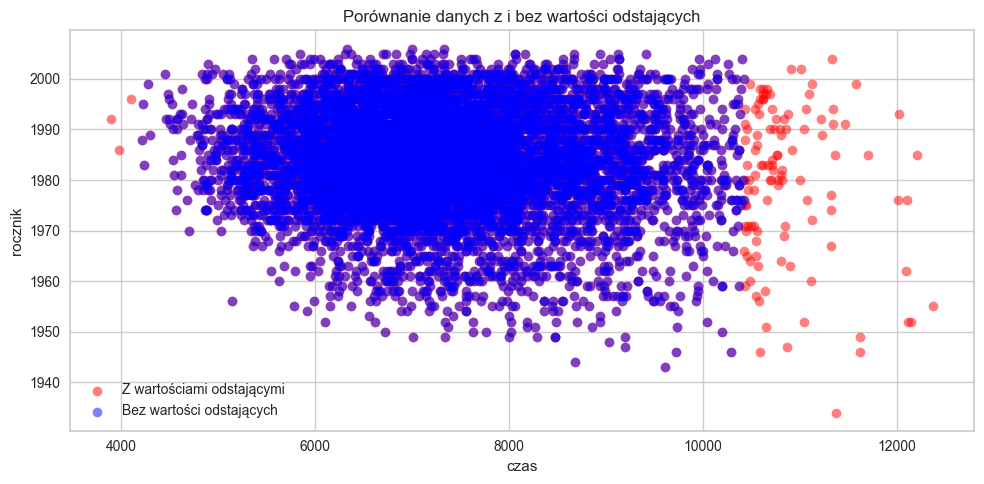

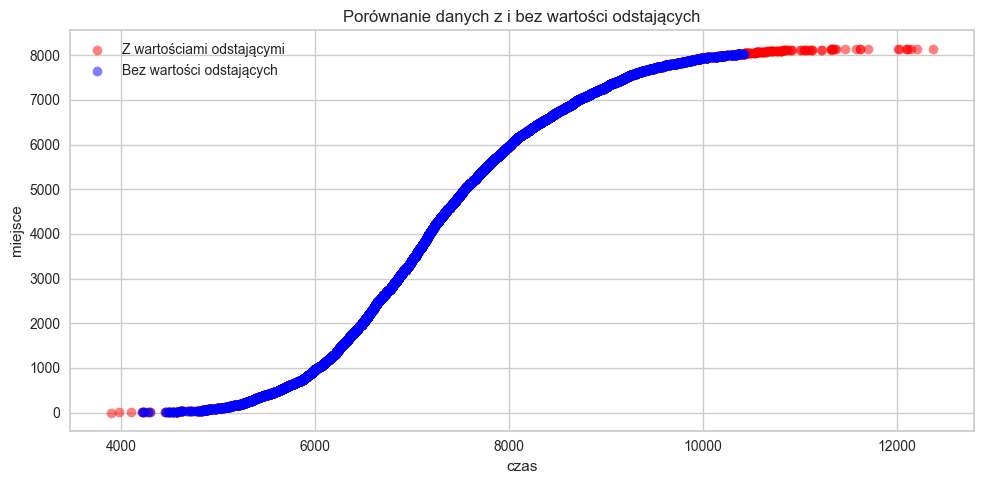

Wczytywanie danych z roku 2024...
Czyszczenie danych w pliku data/raw\halfmarathon_wroclaw_2024__final.csv ...
Zmiana nazw kolumn na małe litery i zamiana spacji na podkreślenia
Usuwanie wierszy z czasem DNS, DNF lub brakiem czasu
Anonimizacja - Usuwanie kolumn: imię, nazwisko, miasto, kraj, drużyna
Zamieniam kolumny czas na czas w sekundach
Zamieniam kolumny tempo min/km na sekundy/km
Sprawdzam ile jest wartości none


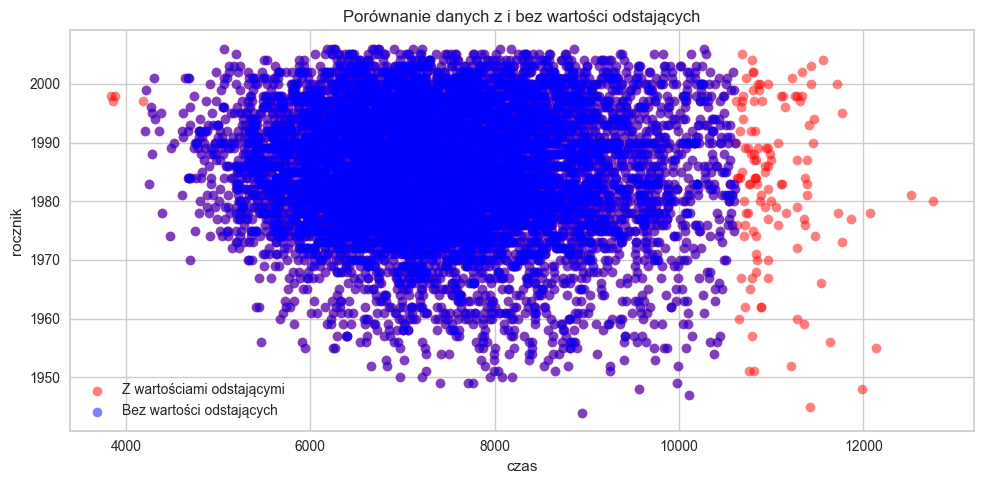

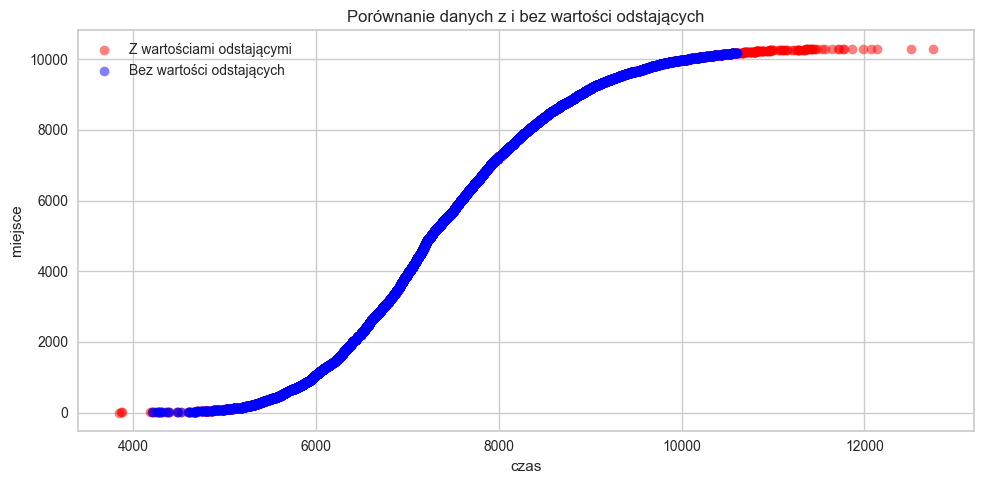

In [78]:
csv_clean_files = glob.glob(os.path.join(LOCAL_RAW_FOLDER, "*.csv"))
clean_data(csv_clean_files)

### Teraz połączę w jeden plik

In [51]:
def merge_csv_files(csv_files, output_path, chunksize=50000):
  
    if not csv_files:
        print("Brak plików CSV w folderze.")
        return False

    try:
        first_file = True  # Flaga dla pierwszego pliku
        for file in csv_files:
            chunk_iter = pd.read_csv(file, sep=";", chunksize=chunksize)
            for chunk in chunk_iter:
                # Dopisujemy pierwszą część z nagłówkami, resztę bez nagłówków
                chunk.to_csv(output_path, mode="w" if first_file else "a", index=False, sep=";", header=first_file)
                first_file = False  # Następne pliki dodajemy bez nagłówków

        print(f"Pliki zostały połączone i zapisane do {output_path}.")
        return True
    except Exception as e:
        print(f"Błąd podczas łączenia plików: {e}")
        return False

In [52]:
MARGED_CLEAN_FILE = "all_cleaned.csv"
csv_clean_files = glob.glob(os.path.join(LOCAL_CURRENT_FOLDER, "*.csv")) #pliki zawirające final
output_file = os.path.join(LOCAL_CURRENT_FOLDER, MARGED_CLEAN_FILE)
merge_csv_files(csv_clean_files,output_file)

Pliki zostały połączone i zapisane do data/current/all_cleaned.csv.


True

## 03. Tworzę model

a dokładnie trzy
* model_5kplace, który na podstawie danych z 5km, przewiduje miejsce na mecie
* model_tempo, który na podstawie danych z 5km, przewiduje tempo na 5km
* model_place, który przewiduje miejsce na mecie na podstawie tempa z 5km

In [54]:
# Ścieżki do modeli
MODEL_PATH_5KPLACE = os.path.join(LOCAL_CURRENT_FOLDER, "model_5kplace")
MODEL_PATH_TEMPO = os.path.join(LOCAL_CURRENT_FOLDER, "model_tempo")
MODEL_PATH_PLACE = os.path.join(LOCAL_CURRENT_FOLDER, "model_place")

In [60]:
def create_model(df, target, model_path):
    
    category_f = ['płeć','rok', 'rocznik']
    
    exp = setup(
            data= df,
            target= target,
            categorical_features=category_f,
            session_id=132
            # verbose=False
        )
    best_models = exp.compare_models(n_select=3)
    best_model = best_models[0] if isinstance(best_models, list) else best_models
    exp.plot_model(best_model, plot='error')
    exp.plot_model(best_model, plot='feature')
    exp.plot_model(best_model, plot='learning')

    exp.predict_model(best_model)

    new_model = finalize_model(best_model)

    exp.save_model(new_model, model_path)
    print(f"Model na podstawie {target} zapisany lokalnie w: {model_path}.pkl")

In [61]:
def create_models():
    file = os.path.join(LOCAL_CURRENT_FOLDER, MARGED_CLEAN_FILE)
    try:
        df = pd.read_csv(file, sep=";")

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.scatterplot(data=df, x="czas", y="miejsce", ax=ax, color="red", edgecolor="red", linewidth=0, alpha=0.5)
        ax.set_title("wyniki Półmaraton Wrocław")
        ax.set_xlabel("Czas")
        ax.set_ylabel("miejsce")
        plt.tight_layout()
        plt.show()

        # df = df[df["rok"] == df["rok"].max()]
        # df = df.sample(n=1000, random_state=42)
        
        df_place5k = df[['płeć','rok', 'rocznik', '5_km_czas', 'miejsce']]
        df_tempo5k = df[['płeć','rok', 'rocznik', '5_km_czas', '5_km_tempo']]
        df_place = df[['płeć','rok', 'rocznik', 'tempo', 'miejsce']]


        print("Wykres danych do modelu")
        # wykres danych
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.scatterplot(data=df, x="czas", y="rocznik", ax=ax, color="red", edgecolor="red", linewidth=0, alpha=0.5)
        ax.set_title("wyniki Półmaraton Wrocław")
        ax.set_xlabel("Czas")
        ax.set_ylabel("Rocznik")
        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.scatterplot(data=df, x="czas", y="miejsce", ax=ax, color="red", edgecolor="red", linewidth=0, alpha=0.5)
        ax.set_title("wyniki Półmaraton Wrocław")
        ax.set_xlabel("Czas")
        ax.set_ylabel("Miejsce")
        plt.tight_layout()
        plt.show()

        ########################
        create_model(df_place5k, "miejsce", MODEL_PATH_5KPLACE)
        create_model(df_tempo5k, "5_km_tempo", MODEL_PATH_TEMPO)
        create_model(df_place, "miejsce", MODEL_PATH_PLACE)
        ########################
        
    except Exception as e:
        print(f"Błąd przygotowywania modelu: {e}")


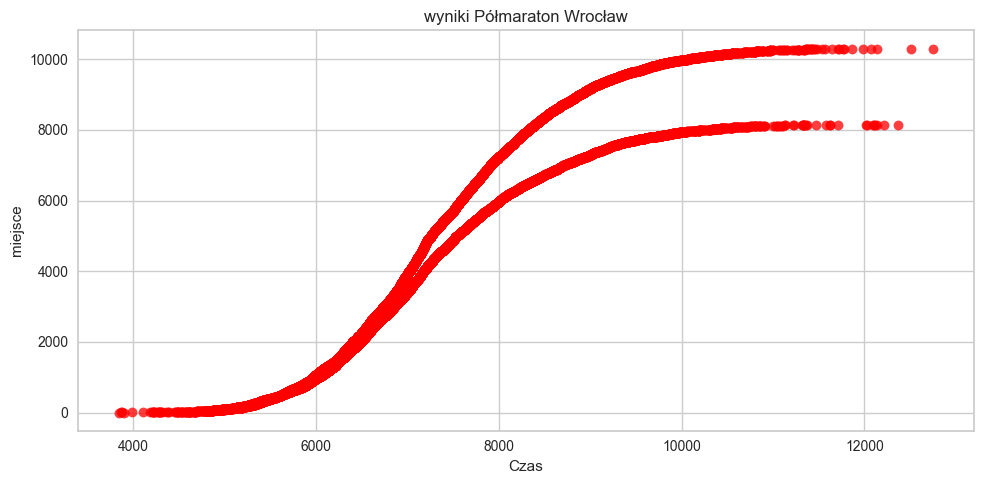

Wykres danych do modelu


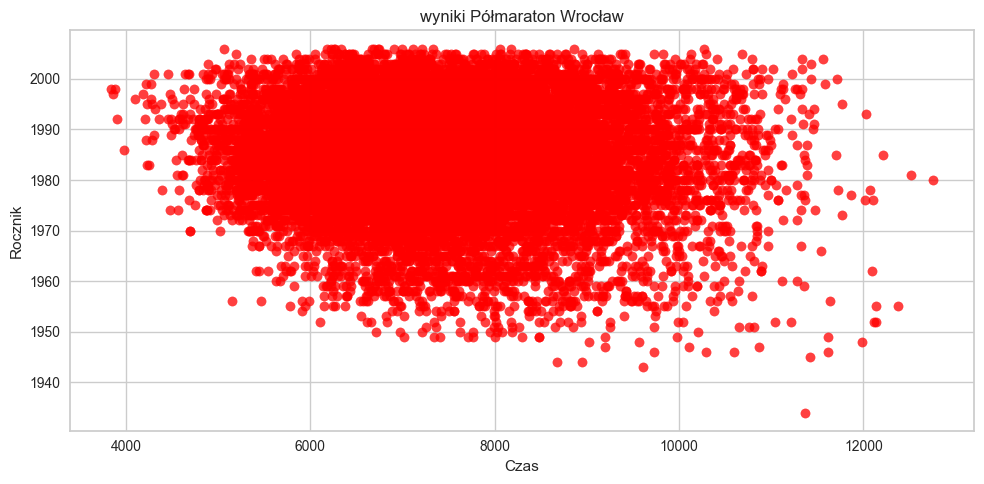

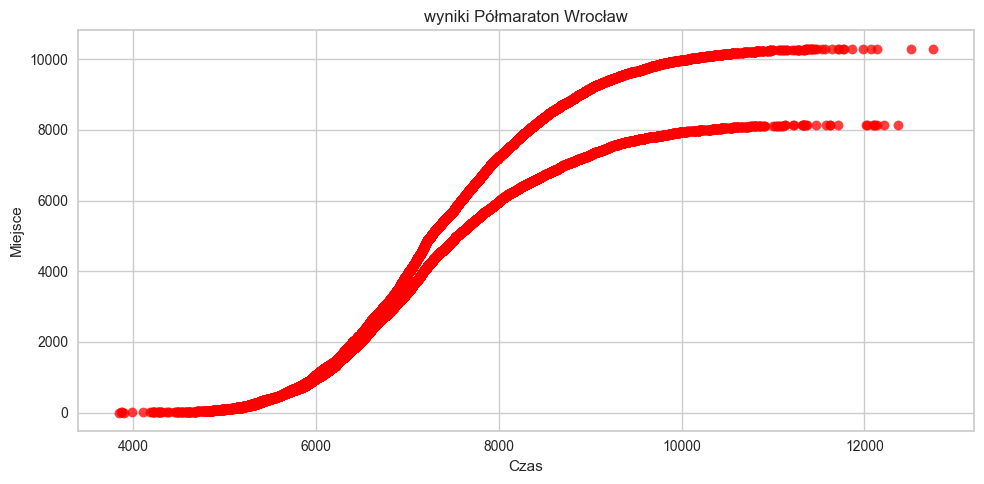

,Description,Value
0,Session id,132
1,Target,miejsce
2,Target type,Regression
3,Original data shape,"(36860, 5)"
4,Transformed data shape,"(36860, 5)"
5,Transformed train set shape,"(25802, 5)"
6,Transformed test set shape,"(11058, 5)"
7,Numeric features,1
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,331.8836,478177.6186,691.0302,0.9376,0.2101,0.1055,1.9390
rf,Random Forest Regressor,459.0101,516252.5702,718.1071,0.9326,0.2241,0.1496,4.0490
dt,Decision Tree Regressor,386.5338,657097.3420,810.3694,0.9142,0.2414,0.1219,0.1870
lightgbm,Light Gradient Boosting Machine,619.3701,748481.3002,864.8411,0.9022,0.2971,0.2398,0.3190
gbr,Gradient Boosting Regressor,625.9828,765191.9712,874.4722,0.9001,0.2961,0.2393,0.9470
knn,K Neighbors Regressor,700.5020,916724.6316,957.2721,0.8803,0.2835,0.2157,0.2570
ridge,Ridge Regression,805.4542,1166706.3937,1079.0907,0.8477,0.5429,1.5718,0.0920
llar,Lasso Least Angle Regression,805.4784,1166717.1605,1079.0932,0.8477,0.5424,1.5720,0.1070
br,Bayesian Ridge,805.4471,1166706.8552,1079.0904,0.8477,0.5427,1.5717,0.0910
lasso,Lasso Regression,805.4784,1166717.1514,1079.0932,0.8477,0.5424,1.5720,0.0960


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

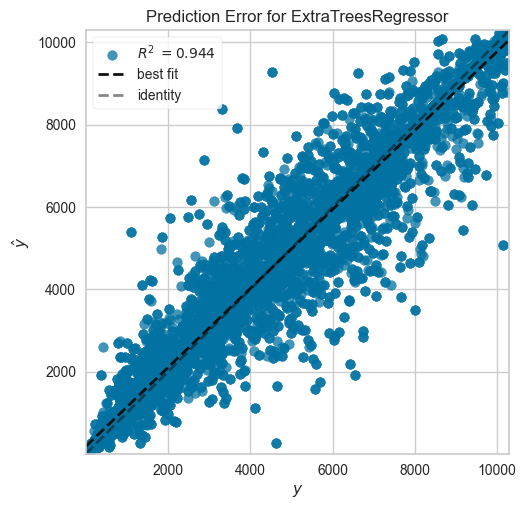

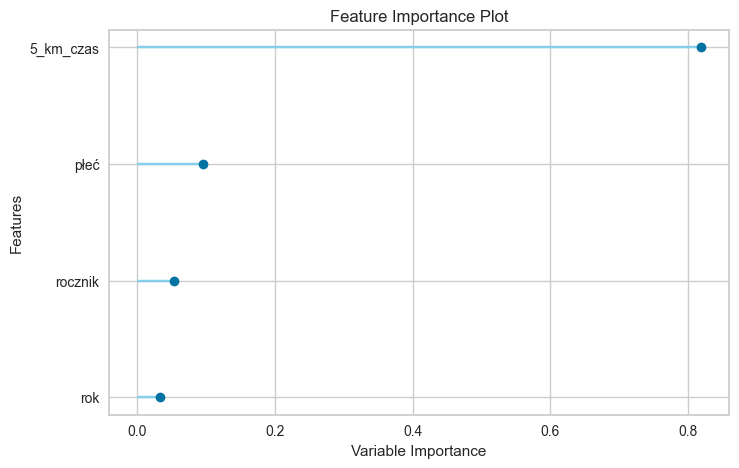

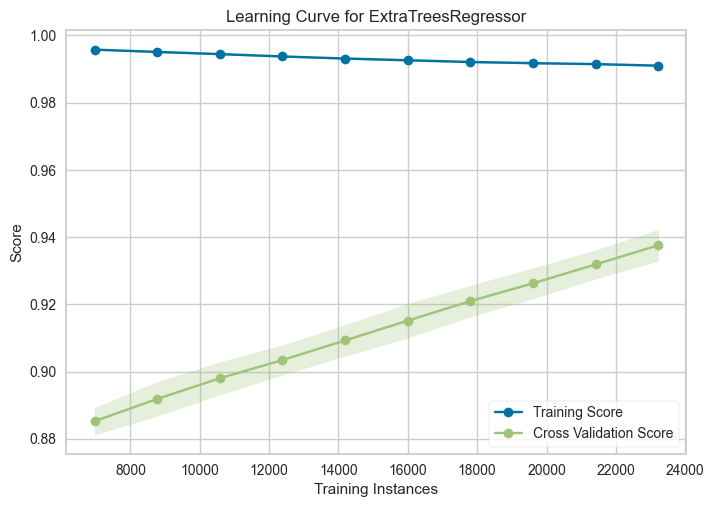

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,295.8105,429042.8907,655.0137,0.9439,0.1972,0.0939


Transformation Pipeline and Model Successfully Saved
Model na podstawie miejsce zapisany lokalnie w: data/current/model_5kplace.pkl


,Description,Value
0,Session id,132
1,Target,5_km_tempo
2,Target type,Regression
3,Original data shape,"(36860, 5)"
4,Transformed data shape,"(36860, 5)"
5,Transformed train set shape,"(25802, 5)"
6,Transformed test set shape,"(11058, 5)"
7,Numeric features,1
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0227,0.8207,0.6486,0.9997,0.0014,0.0001,0.1320
et,Extra Trees Regressor,0.0480,1.0258,0.7788,0.9996,0.0017,0.0001,1.0480
rf,Random Forest Regressor,0.0430,1.7174,0.9379,0.9994,0.0183,0.0001,1.3310
gbr,Gradient Boosting Regressor,0.7349,2.2307,1.4032,0.9991,0.0131,0.0021,0.8080
knn,K Neighbors Regressor,0.3398,5.8594,2.0171,0.9978,0.0234,0.0009,0.1550
lightgbm,Light Gradient Boosting Machine,0.8935,20.2558,4.1209,0.9923,0.0282,0.0025,0.3150
ada,AdaBoost Regressor,7.6497,90.2963,9.4999,0.9651,0.0278,0.0221,0.6100
omp,Orthogonal Matching Pursuit,9.9197,131.8772,11.4836,0.9490,0.0403,0.0286,0.1250
ridge,Ridge Regression,9.9189,131.8332,11.4817,0.9490,0.0402,0.0286,0.1070
huber,Huber Regressor,9.9187,131.8751,11.4835,0.9490,0.0402,0.0286,0.1880


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

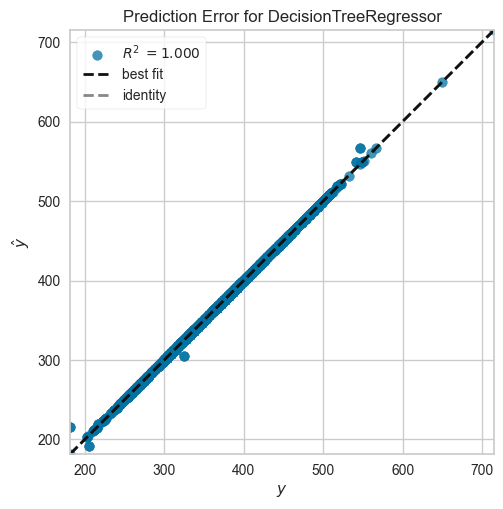

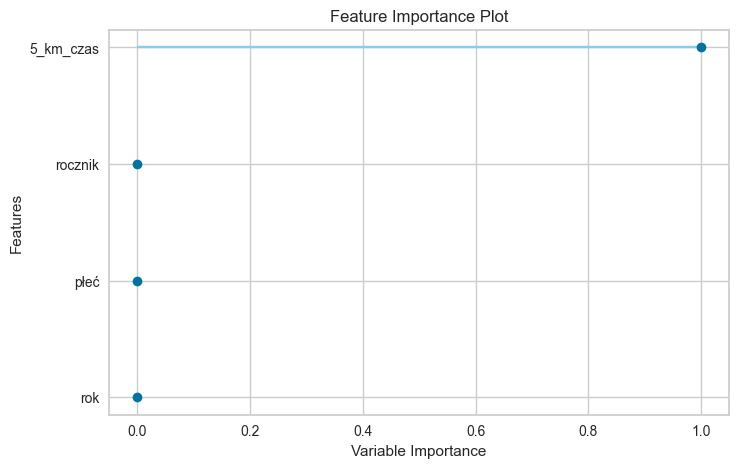

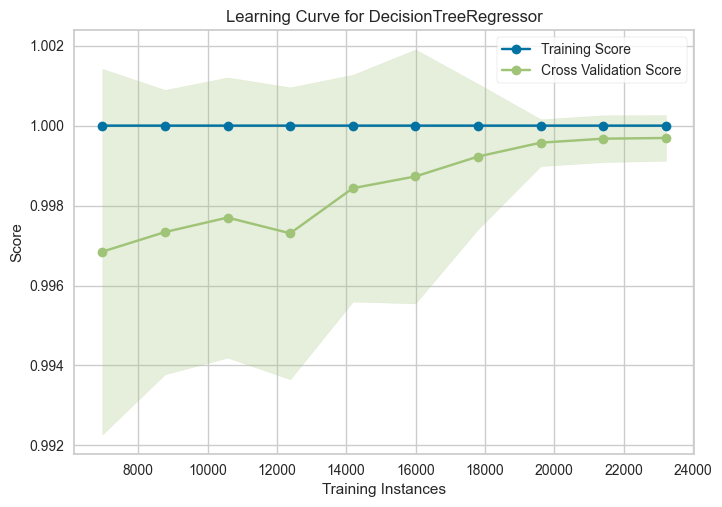

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0192,0.4055,0.6368,0.9998,0.0027,0.0001


Transformation Pipeline and Model Successfully Saved
Model na podstawie 5_km_tempo zapisany lokalnie w: data/current/model_tempo.pkl


,Description,Value
0,Session id,132
1,Target,miejsce
2,Target type,Regression
3,Original data shape,"(36860, 5)"
4,Transformed data shape,"(36860, 5)"
5,Transformed train set shape,"(25802, 5)"
6,Transformed test set shape,"(11058, 5)"
7,Numeric features,1
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,305.0171,230142.0598,479.6679,0.9699,0.2187,0.1296,2.4130
et,Extra Trees Regressor,261.8993,237900.3000,487.6710,0.9689,0.2183,0.1105,1.7000
dt,Decision Tree Regressor,260.4390,252962.8719,502.8611,0.9670,0.2292,0.1094,0.1500
lightgbm,Light Gradient Boosting Machine,411.9071,260109.7824,509.9895,0.9660,0.2572,0.1959,0.3360
gbr,Gradient Boosting Regressor,424.9965,268080.8064,517.7530,0.9650,0.2608,0.2025,0.7520
ada,AdaBoost Regressor,538.3419,346375.5471,588.5205,0.9548,0.4330,0.6352,0.6160
knn,K Neighbors Regressor,472.9286,390984.1948,625.2243,0.9489,0.2478,0.1748,0.1740
llar,Lasso Least Angle Regression,662.4051,781558.2170,883.8608,0.8980,0.4872,1.4053,0.1480
ridge,Ridge Regression,662.8652,781549.8624,883.8560,0.8980,0.4875,1.4057,0.1040
br,Bayesian Ridge,662.8178,781549.9418,883.8560,0.8980,0.4874,1.4056,0.1240


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

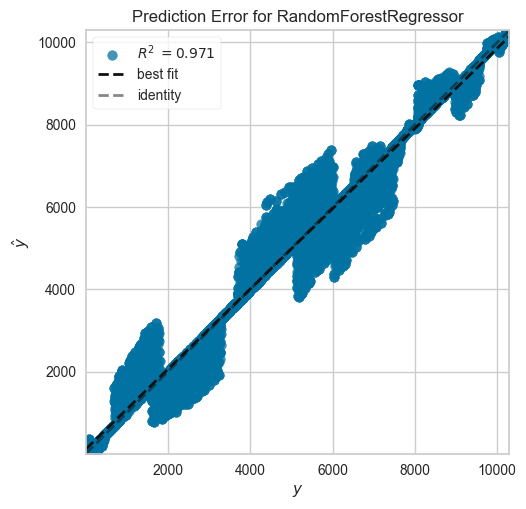

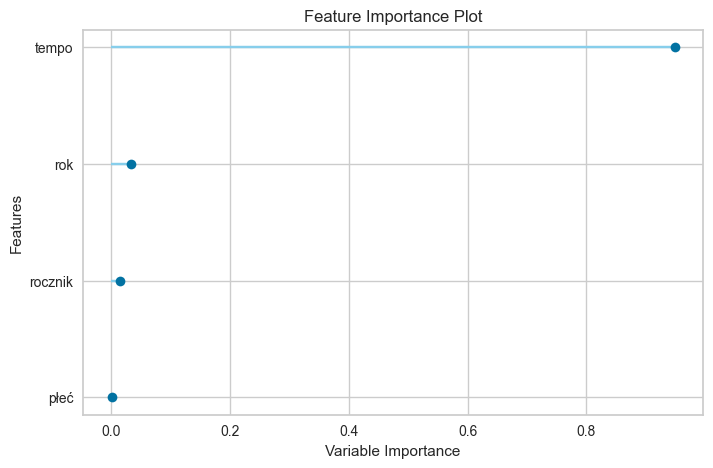

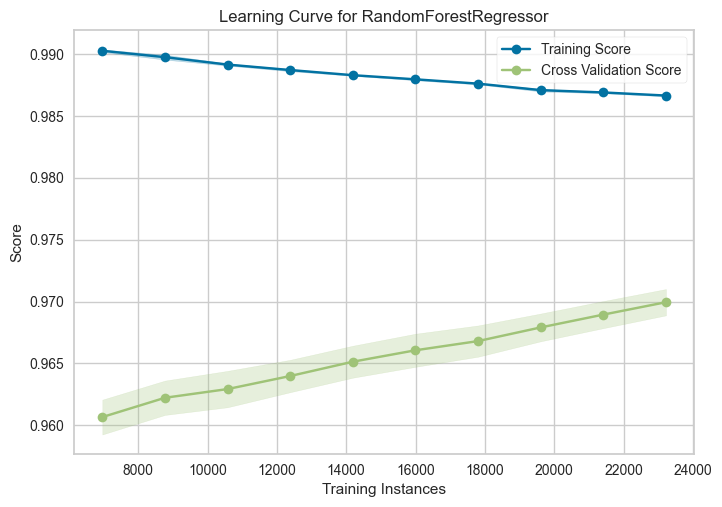

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,294.4264,218106.4644,467.0187,0.9715,0.2056,0.1207


Transformation Pipeline and Model Successfully Saved
Model na podstawie miejsce zapisany lokalnie w: data/current/model_place.pkl


In [62]:
create_models()